# User Trajectory Analyses

In [2]:
import matplotlib.font_manager as font_manager
from os.path import expanduser
import matplotlib as mpl
import seaborn as sns

sns.set_style("ticks")
fontpath = expanduser('/Users/horta/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 16,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': prop.get_name(),
    'text.usetex': True
}
mpl.rcParams.update(params)

In [4]:
from helpers import jaccard, populate_bin_with_channel, add_user_to_bin, bins, bins_t_s, bins_y_s, bin_to_df, \
                    add_user_categories_to_bin, mean_confidence_interval, normalize_user_bins, \
                    find_users_constraint, find_users_other_bin, estimate_for_users
from matplotlib.lines import Line2D
from sqlitedict import SqliteDict
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np

cats = ["Alt-right", "Alt-lite", "Intellectual Dark Web", "Control"]
cats_all = ["Alt-right", "Alt-lite", "Intellectual Dark Web", "left",
            "center", "left-center", "right-center", "right"]
cats_to_control = ["left", "center", "left-center", "right-center", "right"]

def to_control(i):
    cat = i["category"]
    if cat in cats_to_control:
        i["category"] = "Control"
    return i

SRC = "/Users/horta/Dropbox/data/youtube_radicalization/"

In [5]:
df_sources = pd.read_csv(SRC + "sources_final_trimmed.csv")
authors_dict = SqliteDict(SRC + "/helpers/authors_dict.sqlite", tablename="authors", flag="r")
bin_users = {b:dict() for b in bins_y_s}

In [7]:
# min_num_users = 1
# for idx, (key, item) in enumerate(authors_dict.items()):
#     if idx % 1000000 == 0:
#         print(idx)
#     relevant_items = [to_control(i) for i in item if i["category"] in cats_all
#                                           and i["channel_id"] in df_sources.Id.values]
    
    
#     tmp = ["Alt-right", "Alt-lite", "left", "center", "left-center", "right-center", "right"]
# #     relevant_items = [to_control(i) for i in item if (i["category"] in tmp
# #                                           and i["channel_id"] in df_sources.Id.values)
# #                                              or i["channel_id"] in ["UCodkb-qBktJI5NrUsPYpf7g",
# #                                                                    "UCL_f53ZEJxp8TtlOkHwMV9Q"]]
    
#     if len(relevant_items) < min_num_users:
#         continue
#     for comment in relevant_items:
#         add_user_categories_to_bin(bin_users, key, comment["category"], comment["timestamp"])
# normalize_user_bins(bin_users)
# import pickle
# with open(SRC+"bin_users.pickle", "wb") as f:
#     pickle.dump(bin_users, f)
import pickle
with open(SRC+ "/helpers/bin_users.pickle", "rb") as f:
    bin_users = pickle.load(f)

## Trajectories Front (Alt-right)

In [8]:
constraints = [
    lambda x: x["Intellectual Dark Web"] + x["Alt-lite"] == 1,
    lambda x: x["Alt-lite"] == 1,
    lambda x: x["Intellectual Dark Web"] == 1,
    lambda x: x["Control"] == 1
]
    
constraints_names = [
    "Alt-lite or I.D.W.", 
    "Alt-lite", 
    "I.D.W.",  
    "Control"
]

estimates = []


for p in [(1, 3),(3,6), (6,9999)]:
    for lamb, cname in zip(constraints, constraints_names):
        already_tracked = set()

        for start in list(range(4)):
            non_radical = find_users_constraint(bin_users, bins_y_s[start], lamb)
            non_radical = set(non_radical) - set(already_tracked)
            already_tracked = already_tracked.union(non_radical)
            non_radical = list(non_radical)
            
            tmp = estimate_for_users(bin_users, bins_y_s[start], non_radical, 
                                     lambda xs: mean_confidence_interval([p[1] > x["Alt-right"] *  
                                                                          x["count"] >= p[0] for x in xs]))
            
        
            tmp["idxo"] = start
            tmp["idx"] = bins_y_s[start]
            tmp["start"] = start
            tmp["p"] = p
            tmp["numUsersStart"] = len(non_radical)
            tmp["numUsersTracked"] = len(non_radical)
            tmp["pUsersTracked"] = 1
            tmp["constraint"] = cname
            tmp["numUsersInfected"] = 0
            tmp["pUsersInfected"] = 0
            
#             print("Num users start:", len(non_radical))
            estimates.append(tmp)
            count = 0
            for bin_key in bins_y_s[start+1:]:
                count += 1
                tracked_users = find_users_other_bin(bin_users, bin_key, non_radical)

                users_who_watched_ar = find_users_constraint(bin_users, bin_key, 
                          lambda x: p[1] > x["Alt-right"] * x["count"] >= p[0])
                
                tmp = estimate_for_users(bin_users, bin_key, tracked_users,
                                     lambda xs: mean_confidence_interval([p[1] > x["Alt-right"] *  
                                                                          x["count"] >= p[0] for x in xs]))
                

                tmp["idx"] =  bin_key
                tmp["idxo"] = start + count
                tmp["p"] = p
                tmp["start"] = start
                tmp["numUsersStart"] = len(non_radical)
                tmp["numUsersTracked"] = len(tracked_users)
                tmp["pUsersTracked"] = len(tracked_users)/len(non_radical) if len(non_radical) != 0 else 0
                tmp["numUsersInfected"] = len(tracked_users) * tmp["mean"]
                tmp["pUsersInfected"] =  tmp["numUsersInfected"]/len(users_who_watched_ar)

                tmp["constraint"] = cname

#                 print("- Num users tracked: {} \n >> {} out of {}".format(
#                             round(tmp["pUsersTracked"], 2), 
#                             tmp["numUsersTracked"],
#                             tmp["numUsersStart"])
#                      )
                
#                 print("- Num users infected: {} of total {} of tracked \n >> {} out of {} \n {} out of {}".format(
#                             round(tmp["pUsersInfected"], 2), 
#                             round(tmp["mean"], 2), 
#                             tmp["numUsersInfected"],
#                             len(users_who_watched_ar),
#                             tmp["numUsersInfected"],
#                             tmp["numUsersTracked"]
#                          )
#                      )
#                 print()
                estimates.append(tmp)
df = pd.DataFrame(estimates)

bla
bla
bla


findfont: Font family ['Linux Libertine Display'] not found. Falling back to DejaVu Sans.


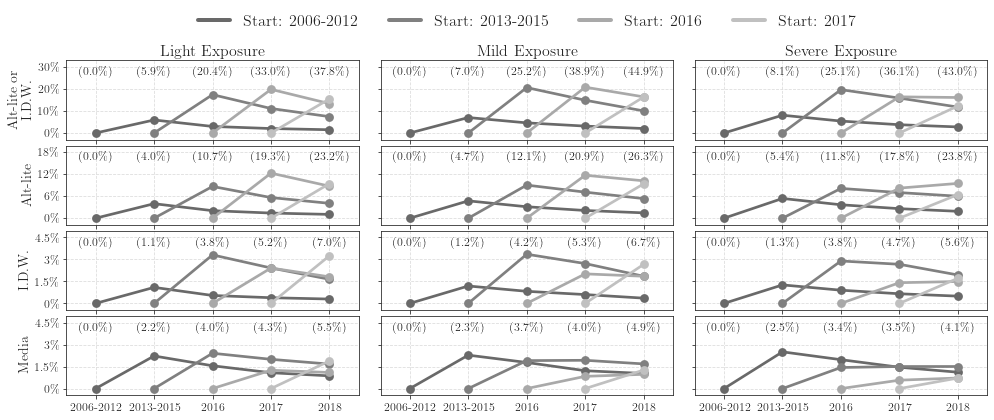

In [9]:
fig = plt.figure(
    constrained_layout=False,
    figsize=(16.5, 6),
)

d_val = {
    (1,3): 0,
    (3,6): 1,
    (6,9999): 2,
}
gs = fig.add_gridspec(nrows=4, ncols=3, wspace=0.075, hspace=0.075, top=0.90)
ylims = [ (-0.03, 0.33), (-0.018, 0.198), (-0.0045, 0.0495), (-.0045, 0.0495)]
yticklabels = [["0\%", "10\%", "20\%", "30\%"], ["0\%", "6\%", "12\%", "18\%"], 
               ["0\%", "1.5\%", "3\%", "4.5\%"], 
                ["0\%", "1.5\%", "3\%", "4.5\%"]]
yticks = [ [0, 0.1, 0.2, 0.3], [0, 0.06,0.12,0.18], [0, 0.015, 0.03, 0.045], 
          [0, 0.015, 0.03, 0.045]]

axs = []
for i in range(12):
    axs.append(fig.add_subplot(gs[i//3, i%3]))
    
for idy, constraint in enumerate(constraints_names):
    for idx, p in enumerate(d_val.keys()):
        ax = axs[idx + idy*3]
        df_tmp = df[(df.constraint == constraint) & (df.p == p)]

        sns.pointplot(x="idxo", y="pUsersInfected", hue="start", data=df_tmp,  lw=2,
                palette=["#696969", "#808080", "#A9A9A9", "#C0C0C0"], legend=False, ax=ax)
        ax.get_legend().remove()
        ax.set_xlabel("")

        if idx == 0:
            ax.set_ylabel(constraint.replace("or ", "or\n").replace("Control", "Media"), fontsize=14)
            ax.set_yticklabels(yticklabels[idy])
        else:
            ax.set_ylabel("")
            ax.set_yticklabels([])
        
        if idy == 3:
            ax.set_xticklabels(bins_t_s)
            print("bla")
        else:
            ax.set_xticklabels([])
            
        ax.set_ylim(ylims[idy])
        ax.set_yticks(yticks[idy])
        ax.xaxis.grid(color="#DCDCDC", linestyle='dashed')
        ax.yaxis.grid(color="#DCDCDC", linestyle='dashed')
        for (k, p), v in df_tmp.groupby(["idxo", "p"]).sum().iterrows():

            ax.text(x=k, y=ylims[idy][1]*0.8, s="(" + str(round(dict(v)["pUsersInfected"]*100, 1)) + "\%)", 
                     rotation=0, horizontalalignment='center', size=12)

        
axs[0].set_title("Light Exposure", pad=5)
axs[1].set_title("Mild Exposure", pad=5)
axs[2].set_title("Severe Exposure", pad=5)

custom_lines = [
    Line2D([0], [0], color="#696969", lw=4),
    Line2D([0], [0], color="#808080", lw=4),
    Line2D([0], [0], color="#A9A9A9", lw=4),
    Line2D([0], [0], color="#C0C0C0", lw=4)
]

axs[1].legend(custom_lines, ["Start: {}".format(b) for b in bins_t_s], 
          loc="center", ncol=4, bbox_to_anchor=(0.5, 1.5), frameon=False, fontsize=16)

fig.savefig("../imgs/user_traj_ptotal.pdf", bbox_inches='tight')
fig.savefig("../imgs/user_traj_ptotal.png", bbox_inches='tight')

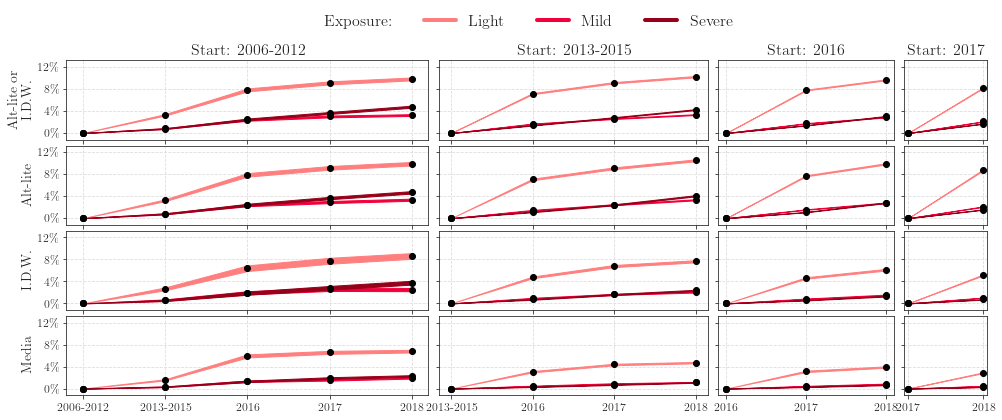

In [10]:
fig = plt.figure(
    constrained_layout=False,
    figsize=(16.5, 6),
)

gs = fig.add_gridspec(nrows=4, ncols=10, wspace=0.125, hspace=0.075, top=0.90)
d_val = {
    (1,3): "#FF7F7F",
    (3,6): "#F2003C",
    (6,9999): "#960018",
}
axs = []

for i in range(4):
    first = fig.add_subplot(gs[i, 0:4])
    axs.append(first)
    axs.append(fig.add_subplot(gs[i, 4:7]))
    axs.append(fig.add_subplot(gs[i, 7:9]))
    axs.append(fig.add_subplot(gs[i, 9]))
    

for idx, constraint in enumerate(constraints_names):
    for start in range(4):
        idy = start
        ax = axs[idy + idx*4]
        df_tmp = df[(df.constraint == constraint) & (df.start == start)]
        for k, idhue in d_val.items():

            df_tmp_ = df_tmp[df_tmp.p == k]
            ax.fill_between(df_tmp_["idxo"], df_tmp_["lower"], 
                            df_tmp_["upper"], color=idhue)
            ax.scatter(df_tmp_["idxo"], df_tmp_["mean"], color="black")
        ax.xaxis.grid(color="#DCDCDC", linestyle='dashed')
        ax.yaxis.grid(color="#DCDCDC", linestyle='dashed')
        ax.set_xticks([i for i in range(start, 5)])
        ax.set_ylim([-0.012,0.132])
        ax.set_yticks([0, 0.04, 0.08, 0.12])
        

        if idy == 0:
            ax.set_ylabel(constraint.replace("or ", "or\n").replace("Control","Media"), fontsize=14)
            ax.set_yticklabels(["0\%", "4\%", "8\%", "12\%"])

        else:
            ax.set_ylabel("")            
            ax.set_yticklabels([])

        if idx == 0:
            ax.set_title("Start: {}".format(bins_t_s[idy]))
            
        if idx == 3:
            ax.set_xticklabels([bins_t_s[i] for i in range(start, 5)])
        else:
            ax.set_xticklabels([])
            
            
custom_lines = [Line2D([0], [0], color="#FF7F7F", lw=0),
                Line2D([0], [0], color="#FF7F7F", lw=4),
        Line2D([0], [0], color="#F2003C", lw=4),
        Line2D([0], [0], color="#960018", lw=4)]

axs[1].legend(custom_lines, ['Exposure:', 'Light', 'Mild', 'Severe'], 
          loc="center", ncol=4,bbox_to_anchor=(0.25, 1.5), frameon=False, fontsize=16)
        

fig.savefig("../imgs/user_traj.pdf", bbox_inches='tight')
fig.savefig("../imgs/user_traj.png", bbox_inches='tight')

In [12]:
df_table = df.groupby(["constraint", "start", "idxo"])["numUsersInfected", 
                                                       "numUsersTracked", 
                                                       "pUsersInfected"].sum()

df_table.numUsersTracked = df_table.numUsersTracked/3
df_table["pUsersTrackedInfected"] = df_table.numUsersInfected/df_table.numUsersTracked

df_table.pUsersInfected = df_table.pUsersInfected.apply(lambda x: "{}%".format(str(round(x*100,2))))
df_table.pUsersTrackedInfected = df_table.pUsersTrackedInfected.apply(lambda x: "{}%".format(str(round(x*100,2))))

print(df_table.to_latex())

\begin{tabular}{lllrrll}
\toprule
       &   &   &  numUsersInfected &  numUsersTracked & pUsersInfected & pUsersTrackedInfected \\
constraint & start & idxo &                   &                  &                &                       \\
\midrule
Alt-lite & 0 & 0 &               0.0 &         170301.0 &           0.0\% &                  0.0\% \\
       &   & 1 &            2132.0 &          43872.0 &         14.06\% &                 4.86\% \\
       &   & 2 &            3426.0 &          27045.0 &          8.83\% &                12.67\% \\
       &   & 3 &            4558.0 &          28944.0 &           6.1\% &                15.75\% \\
       &   & 4 &            6186.0 &          34436.0 &          4.37\% &                17.96\% \\
       & 1 & 1 &               0.0 &         414353.0 &           0.0\% &                  0.0\% \\
       &   & 2 &           12287.0 &         127591.0 &          25.8\% &                 9.63\% \\
       &   & 3 &           16345.0 &         117

/Users/horta/opt/anaconda3/envs/youtube/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
